### moers_bins_v04.ipynb



The content of this Notebook is based on [this](https://automating-gis-processes.github.io/2017/course-info/course-info.html) course from the University of Helsinki.

And the [this](https://mlrose.readthedocs.io/en/stable/source/tutorial2.html) tutorial for solving the Travelling Salesman Problem with `mlrose`.

In [1]:
import mlrose
import numpy as np
import geopandas as gpd
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
from geopandas.tools import geocode
from itertools import chain
from shapely.geometry import LineString, Point

C:\Users\sarah\Anaconda3\envs\geo_py_37\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


### Import street network of Moers from OpenStreetMaps 
#### network_type='bike' or 'drive' or 'walk'

In [2]:
place_name = "Moers, Germany"
graph = ox.graph_from_place(place_name, network_type='drive')
#ox.save_load.save_graph_shapefile(graph, "Moers", folder="Data/")

In [3]:
#ox.save_load.save_as_osm(graph, "Moers", folder="Data/")

In [4]:
nodes, edges = ox.graph_to_gdfs(graph, nodes=True, edges=True)

In [5]:
nodes.crs

'+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs'

### Geocode the starting point (ENNI Betriebshof)

In [6]:
# Geocode addresses with Nominatim backend
start = geocode("Am Jostenhof 7-9, 47441 Moers, Germany", provider='nominatim')
start.crs

{'init': 'epsg:4326', 'no_defs': True}

### Import shapefile (created with QGIS) of bins in Moers

In [7]:
fp = "Data/bins_Moers.shp"
bins = gpd.read_file(fp)
bins.crs

{'init': 'epsg:4326'}

### Reproject the points to the same projection as the road network

In [8]:
proj_text = str.format(edges.crs)

# Reproject the geometries by replacing the values with projected ones
bins = bins.to_crs(proj_text)
#end_point = points_proj.iloc[np.argmin(distances)]
#data_bin_proj.crs = CRS("EPSG:32632")
start = start.to_crs(proj_text)
proj_text

C:\Users\sarah\Anaconda3\envs\geo_py_37\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
C:\Users\sarah\Anaconda3\envs\geo_py_37\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


'+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs'

### Reformat start point

In [9]:
start_point = start.geometry
start_xy = (start_point.y.item(), start_point.x.item())
start_xy

(51.4525429, 6.607198265428346)

### Sample 10 "full" bins

In [10]:
sample_bin = bins.sample(n=10)
sample_bin.head()

,Name,Latitude,Longitude,lfd# Nr#,Stadtteil,Anzahl_beh,ort,Straße,Art,Abfuhrtag,Woche-g-ug,Telefon,Zeitbedarf,geometry
92,Papierkorb 200001509,51.410421,6.602955,1231,None,1,Moers,None,Papierkorb,None,None,None,0.5,POINT (6.60295 51.41042)
929,Papierkorb 200000696,51.456091,6.654228,2068,None,1,Moers,None,Papierkorb,None,None,None,0.5,POINT (6.65423 51.45609)
83,Papierkorb 200001505,51.411496,6.598585,1222,None,1,Moers,None,Papierkorb,None,None,None,0.5,POINT (6.59858 51.41150)
995,Papierkorb 200000864,51.452631,6.659243,2134,None,1,Moers,None,Papierkorb,None,None,None,0.5,POINT (6.65924 51.45263)
373,Papierkorb 200000117,51.456818,6.629335,1512,None,1,Moers,None,Papierkorb,None,None,None,0.5,POINT (6.62934 51.45682)


In [11]:
sample_points = sample_bin.geometry

In [12]:
sample_points

92     POINT (6.60295 51.41042)
929    POINT (6.65423 51.45609)
83     POINT (6.59858 51.41150)
995    POINT (6.65924 51.45263)
373    POINT (6.62934 51.45682)
594    POINT (6.63369 51.47560)
909    POINT (6.65152 51.45484)
691    POINT (6.64982 51.42847)
898    POINT (6.64963 51.45227)
449    POINT (6.59449 51.48334)
Name: geometry, dtype: geometry

In [13]:
sample_xy = []

### Add start point to bin samples

In [14]:
sample_xy.append(start_xy)

In [15]:
sample_xy

[(51.4525429, 6.607198265428346)]

### Reformat points of "full" bins

In [16]:
for index in range(0,sample_points.count()):
    sample_xy.append((sample_points.iloc[index].y, sample_points.iloc[index].x))

In [17]:
sample_xy

[(51.4525429, 6.607198265428346),
 (51.41042062, 6.602954697),
 (51.45609068, 6.654228475),
 (51.41149635, 6.598584708),
 (51.45263121, 6.659243116),
 (51.45681806, 6.62933548),
 (51.47559771, 6.633694824),
 (51.45484077, 6.651521204),
 (51.42846937, 6.649822192),
 (51.4522692, 6.649627984),
 (51.48334309, 6.594488304)]

#### Initialize fitness function object by using a list of coordinates (sample_x_y)

In [18]:
fitness_coords = mlrose.TravellingSales(coords = sample_xy)

#### Define optimization problem object

In [19]:
problem_fit = mlrose.TSPOpt(length = len(sample_xy), fitness_fn = fitness_coords, maximize=False)

In [20]:
# Solve problem using the genetic algorithm
best_state, best_fitness, fitness_curve = mlrose.genetic_alg(problem_fit, mutation_prob = 0.2, max_attempts = 50, random_state = 2, curve = True)

print(best_state)
print(best_fitness)

[ 7  2  8  1  3  0 10  5  6  4  9]
0.271177537135621


In [21]:
#print(fitness_curve)

### Calculate the network nodes that are closest to start and end point

In [22]:
route = []

In [23]:
#route = nx.shortest_path(G=graph, source=orig_node, target=target_node, weight='length')

In [24]:
#fig, ax = ox.plot_graph_route(graph, route, origin_point=orig_xy, destination_point=target_xy, show=False, close=False)

#sample_bin.plot(ax=ax, color='red', markersize=5)

#plt.tight_layout()

In [25]:
for index in range(0,len(sample_xy)):
    
    if index == len(sample_xy):
        orig_xy = sample_xy[best_state[-1]]
        target_xy = sample_xy[best_state[0]]
        print("!!!")
        
    else:
    
        orig_xy = sample_xy[best_state[index]]
        target_xy = sample_xy[best_state[index+1]]
    
    orig_node = ox.get_nearest_node(graph, orig_xy, method='euclidean')
    target_node = ox.get_nearest_node(graph, target_xy, method='euclidean')
    
    #print(orig_node)
    #print(target_node)
    
    route_temp = nx.shortest_path(G=graph, source=orig_node, target=target_node, weight='length')
    print(route)
    route.append(route_temp)
    route_temp = []

[]
[[25752050, 25752053]]
[[25752050, 25752053], [25752053, 25752050, 25752039, 1974493005, 1974493013, 1974492963, 1591399268, 25752088, 25811629, 1740779810, 25734433, 25734217, 582686430, 25734464, 4462284599, 25734351, 3117022940, 25734443, 3117022926, 25734168, 25734231, 25734552, 25734758, 25811692, 78419588, 25734756, 25734739, 603011990, 603011981, 603011984, 603011978, 603011975, 603011969, 25811691, 1309328024, 122268838, 1284612329, 85955279, 115890424, 116877409, 116877497]]
[[25752050, 25752053], [25752053, 25752050, 25752039, 1974493005, 1974493013, 1974492963, 1591399268, 25752088, 25811629, 1740779810, 25734433, 25734217, 582686430, 25734464, 4462284599, 25734351, 3117022940, 25734443, 3117022926, 25734168, 25734231, 25734552, 25734758, 25811692, 78419588, 25734756, 25734739, 603011990, 603011981, 603011984, 603011978, 603011975, 603011969, 25811691, 1309328024, 122268838, 1284612329, 85955279, 115890424, 116877409, 116877497], [116877497, 116877409, 1285952381, 8595526

IndexError: index 11 is out of bounds for axis 0 with size 11

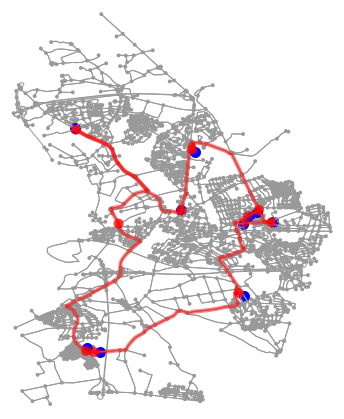

In [26]:
fig, ax = ox.plot_graph_routes(graph, route, save=True, show=False, close=False)

sample_bin.plot(ax=ax, color='blue', markersize=100)

plt.tight_layout()

### Combine the nodes of the route with information from the network

In [27]:
route_nodes = nodes.loc[list(chain(*route))]

In [28]:
print(route_nodes)

                    y         x       osmid          highway  ref  \
25752050    51.454701  6.650967    25752050              NaN  NaN   
25752053    51.456712  6.654768    25752053  traffic_signals  NaN   
25752053    51.456712  6.654768    25752053  traffic_signals  NaN   
25752050    51.454701  6.650967    25752050              NaN  NaN   
25752039    51.453433  6.649243    25752039              NaN  NaN   
...               ...       ...         ...              ...  ...   
2245330349  51.452647  6.655501  2245330349              NaN  NaN   
26138176    51.452638  6.655202    26138176              NaN  NaN   
26138268    51.452552  6.653586    26138268              NaN  NaN   
25811622    51.452518  6.652912    25811622              NaN  NaN   
25752043    51.452374  6.649736    25752043              NaN  NaN   

                            geometry  
25752050    POINT (6.65097 51.45470)  
25752053    POINT (6.65477 51.45671)  
25752053    POINT (6.65477 51.45671)  
25752050    POI

### Convert route into a linestring

In [29]:
route_line = LineString(list(route_nodes.geometry.values))
print(route_line)

LINESTRING (6.6509669 51.4547012, 6.6547681 51.4567119, 6.6547681 51.4567119, 6.6509669 51.4547012, 6.6492434 51.4534329, 6.6470412 51.4525657, 6.646854 51.4526114, 6.6468025 51.4524743, 6.6469161 51.4524426, 6.6469716 51.4522432, 6.6470329 51.4520679, 6.6475809 51.4503085, 6.6475099 51.4501076, 6.6473962 51.4500481, 6.6473998 51.449939, 6.6475648 51.4498789, 6.6477445 51.4496664, 6.6482323 51.4489172, 6.6484838 51.4474982, 6.6483767 51.4474259, 6.6485106 51.4473435, 6.6486317 51.4466234, 6.6490432 51.4445734, 6.6502283 51.4442636, 6.6496852 51.4436269, 6.6492276 51.4433298, 6.6480679 51.4429744, 6.6478679 51.4429244, 6.6469383 51.44263, 6.645217 51.4418802, 6.6450695 51.4419036, 6.6450298 51.4418086, 6.6430253 51.4413833, 6.6428814 51.4414177, 6.642834 51.4413418, 6.6416601 51.4409792, 6.644156 51.4371712, 6.6453325 51.4354314, 6.6478123 51.4317, 6.6475678 51.4313098, 6.6472914 51.4307705, 6.6469827 51.4294891, 6.6481987 51.4295508, 6.6481987 51.4295508, 6.6469827 51.4294891, 6.647750

### Create a GeoDataFrame from the linestring

In [30]:
route_geom = gpd.GeoDataFrame(crs=edges.crs)

route_geom['geometry'] = None
route_geom['osmids'] = None

In [31]:
route_geom.loc[0, 'geometry'] = route_line

route_geom.loc[0, 'osmids'] = str(list(route_nodes['osmid'].values))

### Plot the route as dashed line onto the nodes and edges of the network

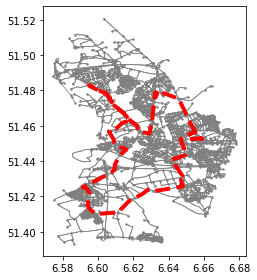

In [32]:
fig, ax = plt.subplots()
edges.plot(ax=ax, linewidth=0.75, color='gray')
nodes.plot(ax=ax, markersize=2, color='gray')
route_geom.plot(ax=ax, linewidth=4, linestyle='--', color='red')
plt.tight_layout()

### Prepare the saving of shapefiles

In [33]:
place_name_out = place_name.replace(' ', '_').replace(',','')
#streets_out = r"Data/%s_streets.shp" % place_name_out
route_out = r"Data/Route_%s.shp" % place_name_out

In [34]:
#edges.to_file(streets_out)

In [35]:
route_geom.to_file(route_out)

In [36]:
route

[[25752050, 25752053],
 [25752053,
  25752050,
  25752039,
  1974493005,
  1974493013,
  1974492963,
  1591399268,
  25752088,
  25811629,
  1740779810,
  25734433,
  25734217,
  582686430,
  25734464,
  4462284599,
  25734351,
  3117022940,
  25734443,
  3117022926,
  25734168,
  25734231,
  25734552,
  25734758,
  25811692,
  78419588,
  25734756,
  25734739,
  603011990,
  603011981,
  603011984,
  603011978,
  603011975,
  603011969,
  25811691,
  1309328024,
  122268838,
  1284612329,
  85955279,
  115890424,
  116877409,
  116877497],
 [116877497,
  116877409,
  1285952381,
  85955264,
  85955260,
  85955253,
  115904966,
  266739019,
  266739130,
  3342199679,
  1229130104,
  281162017,
  291907327,
  1283829171,
  1296182258,
  410459729],
 [410459729, 835586234, 459540030],
 [459540030,
  80068486,
  291524122,
  291524129,
  346970232,
  80068501,
  370155672,
  254541878,
  528012365,
  254541876,
  410295850,
  410448894,
  1548016706,
  1548016750,
  1545014472,
  15450146